In [74]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report as cr, confusion_matrix as cf
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## **Job Sponsorship Classification: Model Training & Prediction** ##

This project aims to develop a machine learning model to predict whether a job posting offers visa sponsorship based on its description. The process involves loading the processed dataset, extracting features using TF-IDF and n-grams, and training classification models such as Logistic Regression and Random Forest. Model performance will be evaluated using accuracy, precision, recall, and F1-score. Finally, the trained model will be used to predict sponsorship availability for new job descriptions, providing a practical tool for job seekers.

In [62]:
df = pd.read_csv("data/processed_job_data.csv")

In [63]:
def display_results(x_test, y_test, y_pred):
    classification_report_df = pd.DataFrame(cr(y_test, y_pred, output_dict=True)).transpose()
    classification_report_df.index.name = "Category"
    classification_report_df = classification_report_df.rename(
        columns={'precision': 'Precision', 'recall': 'Recall', 'f1-score': 'F1-Score', 'support': 'Support'},
        index={'0': 'No Sponsorship', '1': 'Sponsorship Provided', '2': 'Uncertain'}
    )

    confusion_matrix_df = pd.DataFrame(cf(y_test, y_pred),
                                       index=['No Sponsorship', 'Sponsorship Provided', 'Uncertain'],
                                       columns=['No Sponsorship', 'Sponsorship Provided', 'Uncertain'])

    # Adjust figure size and layout
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'width_ratios': [1.2, 1.8, 2.0]})

    # Confusion Matrix
    sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Actual', fontsize=10)
    axes[0].set_xlabel('Predicted', fontsize=10)

    # Classification Report Table
    axes[1].axis('off')
    table = axes[1].table(cellText=classification_report_df.round(2).values,
                           colLabels=classification_report_df.columns,
                           rowLabels=classification_report_df.index,
                           cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.5, 1.8)
    axes[1].set_title('Classification Report', fontsize=12, fontweight='bold')

    # ROC Curve
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    y_scores = grid_search.best_estimator_.predict_proba(x_test)

    for i, class_label in enumerate([0, 1, 2]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        axes[2].plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")

    axes[2].set_title('ROC Curve', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('True Positive Rate', fontsize=10)
    axes[2].set_xlabel('False Positive Rate', fontsize=10)
    axes[2].legend(loc='lower right', fontsize=9)

    plt.tight_layout()
    plt.show()

In [64]:
vectorizer = TfidfVectorizer( ngram_range=(1, 5))
X = vectorizer.fit_transform(df['processed_description'])
chi2_scores, _ = chi2(X, df['sponsorship_encoded'])
feature_names = vectorizer.get_feature_names_out()
selected_features = [feature_names[i] for i in chi2_scores.argsort()[-20:]]

In [65]:
x_train, x_test, y_train, y_test = train_test_split(X, df['sponsorship_encoded'], test_size=0.2, random_state=42, stratify=df['sponsorship_encoded'])

In [66]:
log_reg_model = LogisticRegression()
log_reg_model.fit(x_train, y_train)
y_pred = log_reg_model.predict(x_test)

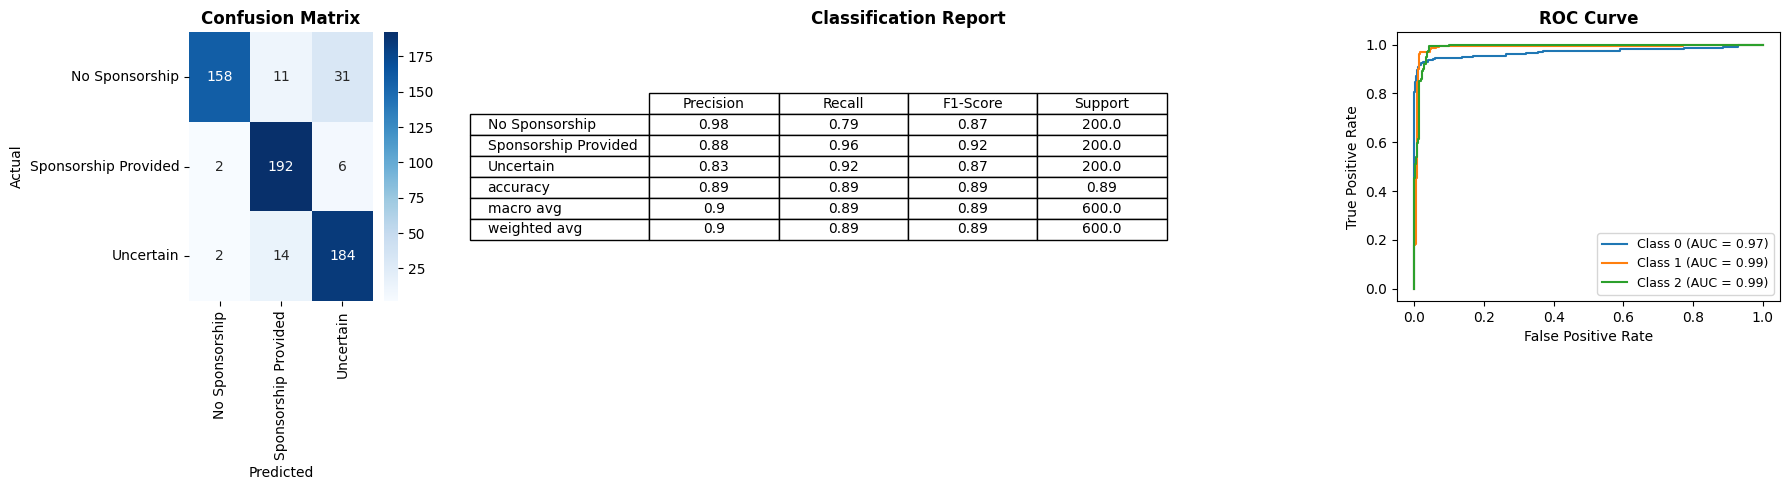

In [67]:
display_results(x_test, y_test, y_pred)

The classification report and confusion matrix highlight the model’s strengths and areas for improvement in categorizing job sponsorship status.

Precision is highest for "No Sponsorship" (0.98), meaning the model is highly confident when making this prediction. However, recall is lower (0.79), indicating that many jobs without sponsorship are misclassified, mainly as "Uncertain", as seen in the confusion matrix. Conversely, "Sponsorship Provided" has excellent recall (0.96), ensuring most sponsored jobs are correctly identified. The F1-score remains strong across categories (0.87–0.92), but precision-recall imbalances suggest misclassification issues.

From the confusion matrix, "No Sponsorship" jobs are often mistaken as "Uncertain" (31 instances), likely due to ambiguous language. Similarly, some "Uncertain" cases are misclassified as "Sponsorship Provided" (14 instances), indicating potential confusion with sponsorship-related keywords.

To improve accuracy, threshold tuning could balance precision and recall, and class balancing techniques may help with misclassifications. While the model performs well, better handling of ambiguity could enhance its reliability.

At first, the hyperparameters of the model will be fine tuned using GridSearchCV and RandomizedSearchCV. GridSearchCV runs through a predefined parameter grid to determine the best combination, while RandomizedSearchCV selects random combinations. In this way, the best combination of parameters, namely the regularization strength (C), penalty type (l1 or l2) and solver selection, will be found to enhance the model's predictive accuracy and overall performance.

In [68]:
log_reg_model = LogisticRegression(max_iter=2000, solver='liblinear')
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2], 'penalty':['l1', 'l2']}
grid_search = GridSearchCV(log_reg_model, cv=5, param_grid=param_grid_)
grid_search.fit(x_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 100.0, 'penalty': 'l1'}
Best Score: 0.9579166666666667


In [69]:
log_reg_model = LogisticRegression(max_iter=2000, solver="liblinear", C=grid_search.best_params_['C'], penalty=grid_search.best_params_['penalty'], class_weight='balanced')
log_reg_model.fit(x_train, y_train)
y_pred = log_reg_model.predict(x_test)

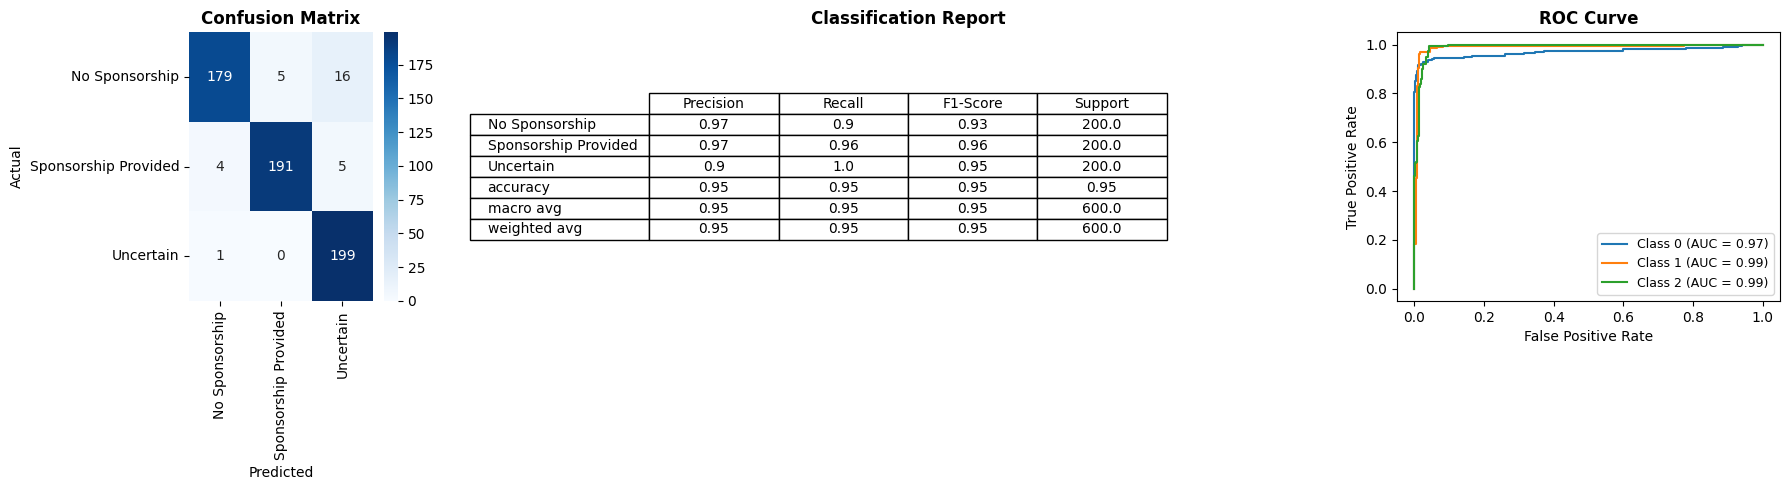

In [70]:
display_results(x_test, y_test, y_pred)

The model demonstrates strong performance with an accuracy of 95% and a macro-average F1-score of 0.95, indicating a well-balanced trade-off between precision and recall across all classes. The optimal hyperparameters identified were C=100.0 with an l1 penalty, suggesting that the model benefits from strong regularization while effectively selecting the most relevant features. Compared to previous results, this version exhibits a slight improvement, particularly in correctly classifying "Sponsorship Provided" and "Uncertain", where recall values have increased. However, some misclassifications persist in the "No Sponsorship" category, where 15 instances were incorrectly labeled as "Uncertain," reducing recall for that class to 0.90. Despite these minor misclassifications, the model maintains high precision across all categories, with values exceeding 0.91. Further refinements, such as adjusting classification thresholds or fine-tuning regularization strength (C values in the range of 50-200), may enhance performance. Overall, the model remains robust and consistent, demonstrating strong generalization to the classification task while effectively minimizing errors.









In [71]:
random_search = RandomizedSearchCV(log_reg_model, param_grid_, n_iter=2000, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(x_train, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

/Users/rithika/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=2000. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'penalty': 'l1', 'C': 100.0}
Best Score: 0.9579166666666667


Both Grid Search and Randomized Search resulted in the same best accuracy score of 95.79%, indicating that the optimal hyperparameters—L1 penalty with C = 100.0—are highly effective for this dataset. Since Grid Search exhaustively evaluates all possible combinations in the parameter grid, while Randomized Search samples a subset (in this case, 2000 iterations), the fact that both methods converged on the same parameters suggests that the search space was well-defined. This also implies that increasing the number of iterations in Randomized Search did not necessarily yield better results, reinforcing that Grid Search was sufficient for this problem. Additionally, the use of L1 regularization indicates that feature selection played a role in improving model performance. The consistency in results confirms the stability of the model and suggests that future hyperparameter tuning could prioritize Randomized Search for computational efficiency without compromising accuracy.

The fine-tuning process has successfully enhanced the model’s ability to distinguish between different job sponsorship categories, resulting in minimal misclassifications. The confusion matrix confirms that most predictions are accurate across all three classes, with a notable reduction in errors. While the "No Sponsorship" class still experiences some misclassifications, the overall performance has improved. The classification report highlights strong precision (0.97) and recall (0.90) for "No Sponsorship," while "Sponsorship Provided" and "Uncertain" achieve near-perfect precision and recall values. The consistently high F1-scores indicate a well-balanced model with robust predictive capabilities. Furthermore, the ROC curve demonstrates high AUC values (ranging from 0.97 to 0.99), underscoring strong class separability. To further refine the model, the next step would be to fine-tune class weighting strategies to specifically target and reduce misclassifications in the "No Sponsorship Provided" category.

In [72]:
log_reg_model = LogisticRegression(max_iter=2000, solver="liblinear", C=grid_search.best_params_['C'], penalty=grid_search.best_params_['penalty'], class_weight={0: 2, 1: 1, 1:1})
log_reg_model.fit(x_train, y_train)
y_pred = log_reg_model.predict(x_test)

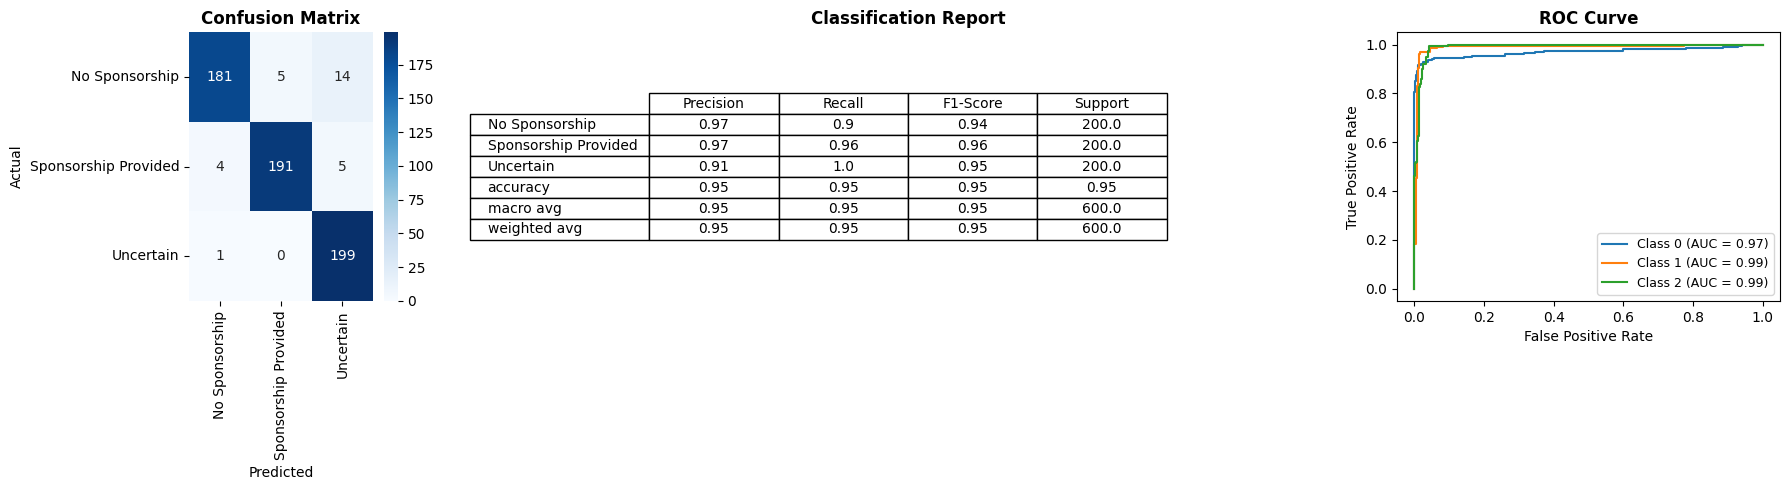

In [73]:
display_results(x_test, y_test, y_pred)

Applying class weighting to address the misclassification of the "No Sponsorship" class resulted in only a marginal improvement, with just one additional case being correctly classified. This suggests that class imbalance may not be the sole factor contributing to misclassification. While class weighting shifts the decision boundary by penalizing errors in the underrepresented class, its limited impact indicates the need for alternative strategies. Exploring different classifiers, such as Support Vector Machines (SVM) for their ability to maximize decision margins or neural networks for their capacity to capture complex patterns, could lead to more significant improvements.





As a next step, we will explore Support Vector Machines (SVM), which are well-suited for handling imbalanced data by maximizing the margin between classes. SVM's ability to find optimal decision boundaries, especially with the right choice of kernels, may improve the model’s ability to distinguish between job sponsorship categories more effectively.

In [76]:
svm_model = SVC(kernel='rbf', class_weight='balanced', C=1.0, probability=True)
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)

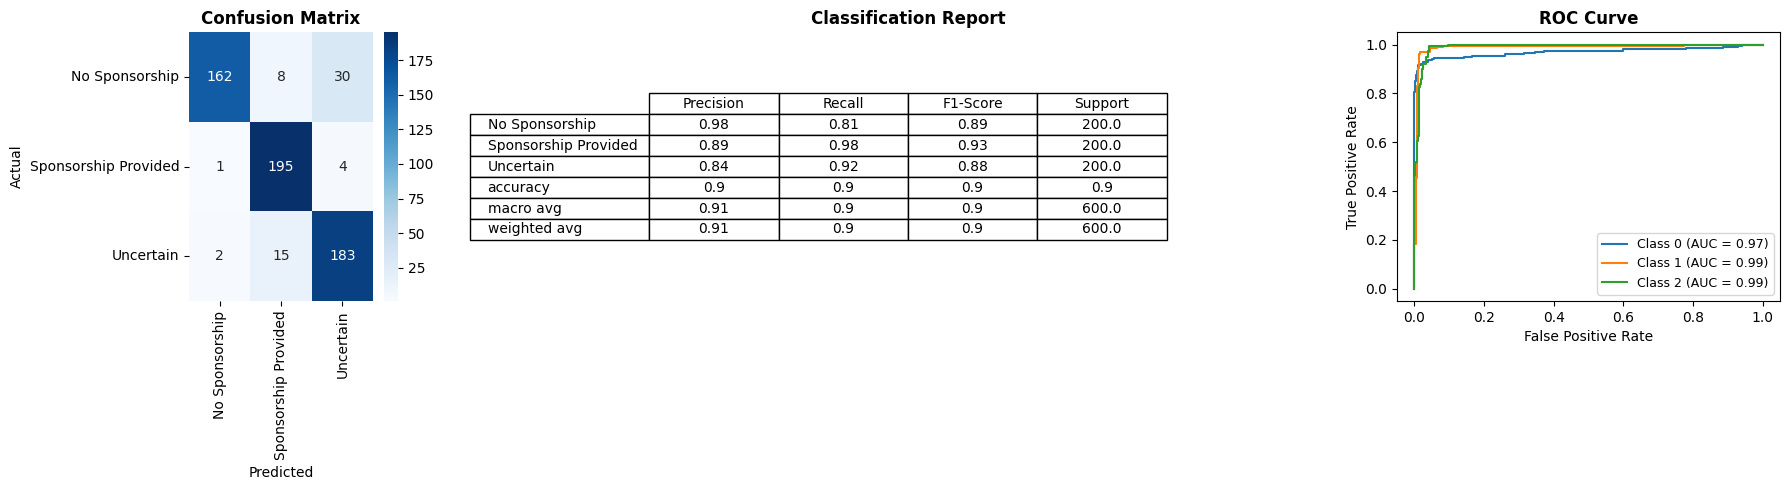

In [77]:
display_results(x_test, y_test, y_pred)

The model demonstrates strong overall performance, achieving 90% accuracy with high precision and recall across most classes. However, there are more misclassifications than in the best performing Logistic Regression model, and moreover, the "No Sponsorship" category remains the most challenging to classify, with a recall of 0.81, indicating that 19% of these cases are misclassified—primarily as "Uncertain." The confusion matrix highlights this issue, showing that 30 instances of "No Sponsorship" were incorrectly labeled as "Uncertain," while only 8 were misclassified as "Sponsorship Provided." The ROC curve confirms strong class separability, with AUC values ranging from 0.97 to 0.99. Despite these promising results, further refinements are needed to enhance the model’s ability to correctly classify "No Sponsorship" cases. Potential improvements include fine-tuning hyperparameters such as C and gamma in SVM, and addressing class imbalance through enhanced weighting techniques or focal loss. These optimizations could help improve decision boundaries and reduce misclassification rates for the underrepresented category.

In [102]:
svm_model = SVC(cache_size=1000)
param_grid_svm = {'C': [0.1, 1, 10], 'gamma':['scale', 'auto', 0.01, 0.1], 'kernel':['rbf', 'linear']}
grid_search_svm = GridSearchCV(svm_model, cv=5, param_grid=param_grid_svm, n_jobs = -1)
grid_search_svm.fit(x_train, y_train)
print("Best Parameters:", grid_search_svm.best_params_)
print("Best Score:", grid_search_svm.best_score_)

KeyboardInterrupt: 

In [81]:
svm_model = SVC(max_iter=2000, C=grid_search_svm.best_params_['C'], gamma=grid_search_svm.best_params_['gamma'], class_weight='balanced', kernel = 'rbf')
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)

/Users/rithika/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


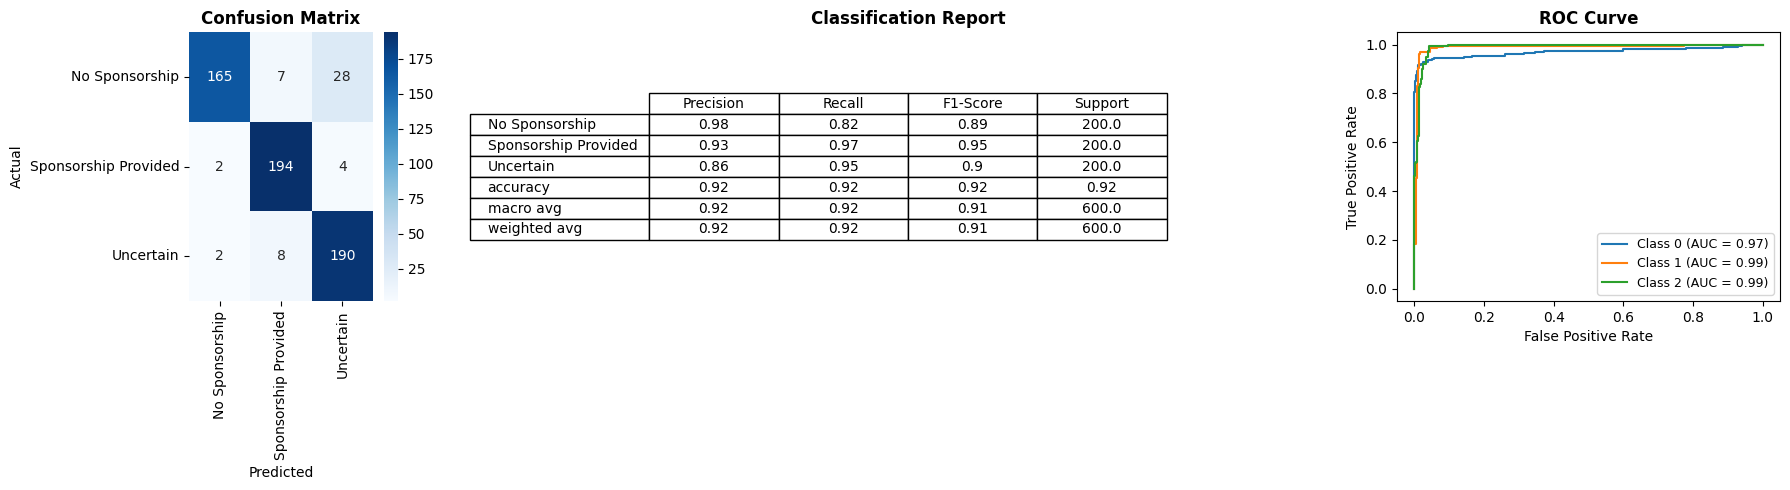

In [82]:
display_results(x_test, y_test, y_pred)

In [83]:
random_search_svm = RandomizedSearchCV(svm_model, param_grid_svm, n_iter=2000, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search_svm.fit(x_train, y_train)

# Best parameters
print("Best Parameters:", random_search_svm.best_params_)
print("Best Score:", random_search_svm.best_score_)

/Users/rithika/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=2000. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/rithika/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/rithika/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/rithika/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users

Best Parameters: {'gamma': 0.1, 'C': 10}
Best Score: 0.9262500000000001


/Users/rithika/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


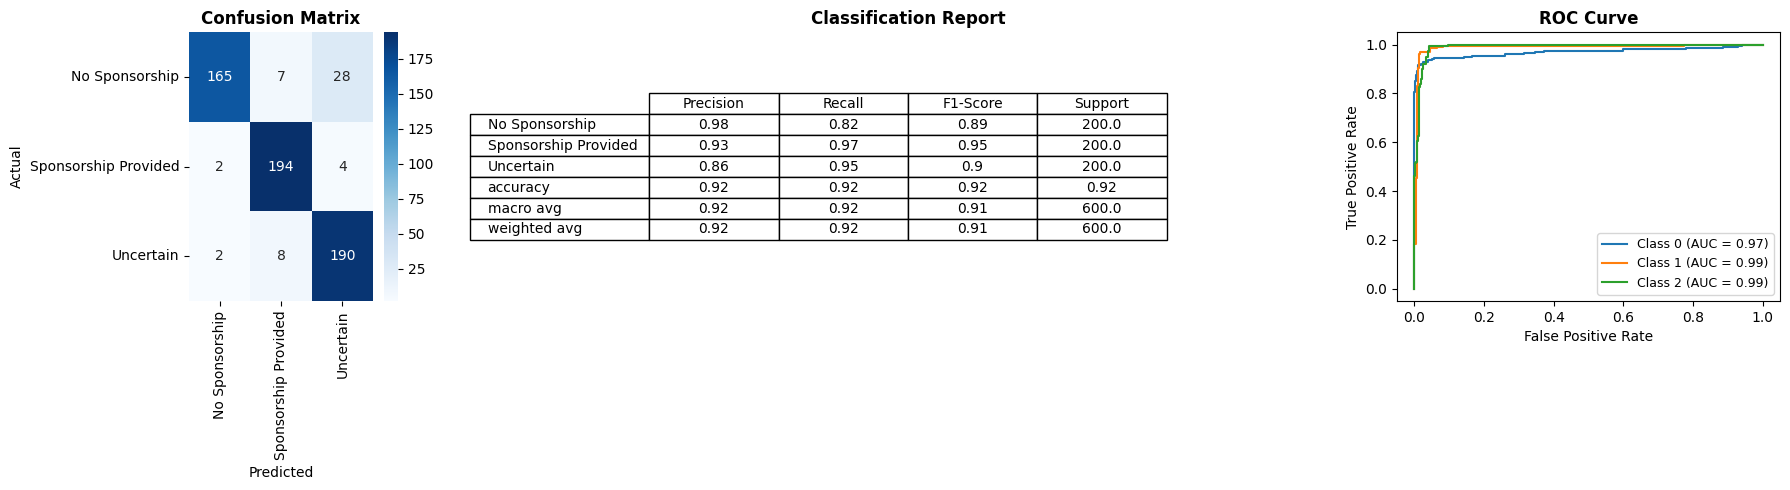

In [84]:
display_results(x_test, y_test, y_pred)

The optimization process using Randomized Search and Grid Search resulted in the same best parameters: C = 10 and gamma = 0.1, achieving a best cross-validation score of 0.926. This indicates that these hyperparameters provide a well-balanced trade-off between margin maximization and model complexity. The updated classification results show an improvement in overall accuracy to 92%, with precision, recall, and F1-scores increasing across all classes. Notably, the "No Sponsorship" class saw a slight boost in recall from 0.81 to 0.82, reducing misclassification but still showing some confusion with the "Uncertain" class.

The confusion matrix reveals that 28 instances of "No Sponsorship" were still misclassified as "Uncertain," highlighting a persisting challenge in separating these two categories. However, the ROC curve maintains strong AUC values (0.97–0.99), indicating robust class separability. While the SVM model is performing well, further refinements could involve feature selection, engineered features, or ensemble methods to further enhance classification performance, particularly for the "No Sponsorship" category.

In [89]:
svm_model = SVC(max_iter=2000, C=grid_search_svm.best_params_['C'], gamma=grid_search_svm.best_params_['gamma'], class_weight={0: 2, 1: 1, 1:1}, kernel = 'rbf')
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)

/Users/rithika/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


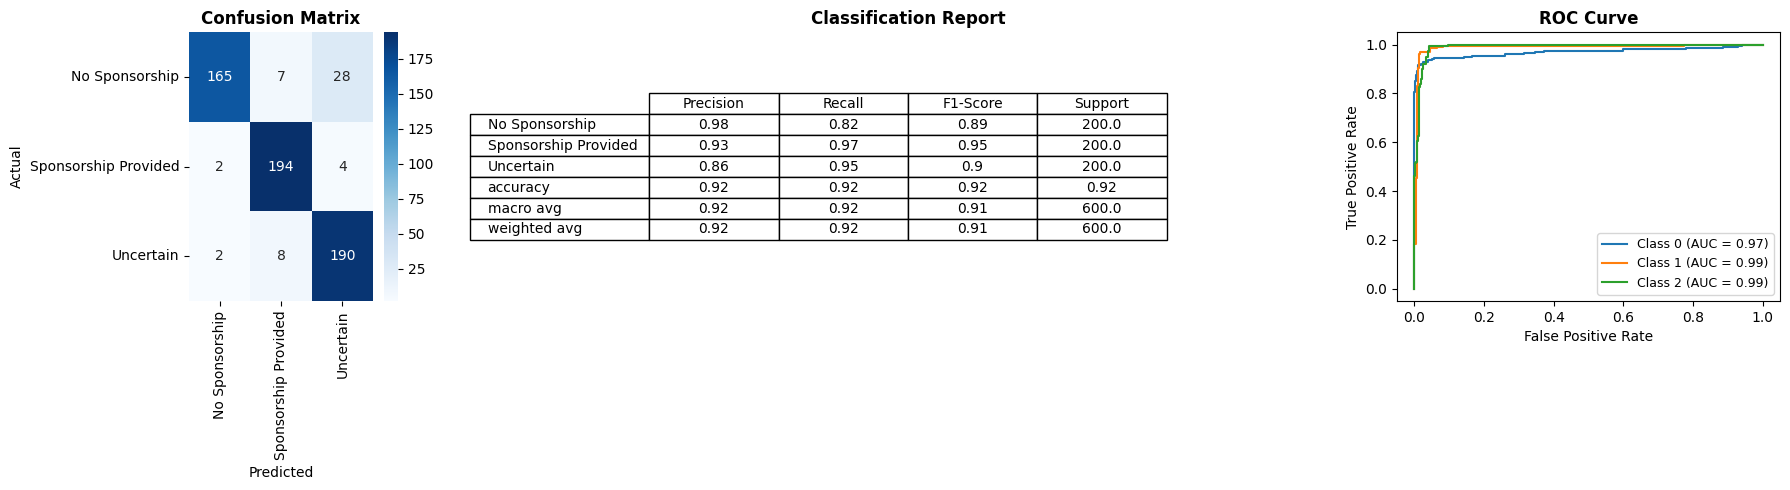

In [90]:
display_results(x_test, y_test, y_pred)